### Install and Import Third Party Dependencies

In [1]:
%pip install pandas numpy matplotlib seaborn scipy

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

### Initialize datasets and columns for outlier detection

In [32]:
# Load dataset (update the file path if needed)
df = pd.read_csv("data.csv")

# Select numeric columns for outlier detection
df_numeric = df.select_dtypes(include='number')

# Add the 'title' column to the numeric DataFrame
df_numeric = pd.concat([df[['title']], df_numeric], axis=1)

# Display dataset info and summary
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20877 entries, 0 to 20876
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               20225 non-null  object 
 1   type                20877 non-null  object 
 2   genres              20530 non-null  object 
 3   releaseYear         20842 non-null  float64
 4   imdbId              19356 non-null  object 
 5   imdbAverageRating   19166 non-null  float64
 6   imdbNumVotes        19166 non-null  float64
 7   availableCountries  166 non-null    object 
dtypes: float64(3), object(5)
memory usage: 1.3+ MB
None
        releaseYear  imdbAverageRating  imdbNumVotes
count  20842.000000       19166.000000  1.916600e+04
mean    2013.250744           6.395393  3.169231e+04
std       14.315295           1.094817  1.202100e+05
min     1913.000000           1.200000  5.000000e+00
25%     2012.000000           5.700000  3.262500e+02
50%     2018.000000        

### Outliers Detected using Z-score

In [24]:
df_z = df_numeric

# Calculate the mean and standard deviation for 'imdbNumVotes'
mean_votes = df_z['imdbNumVotes'].mean()
std_votes = df_z['imdbNumVotes'].std()

# Calculate the Z-scores
df_z['z_score'] = (df_z['imdbNumVotes'] - mean_votes) / std_votes

# Define the threshold for identifying outliers
threshold = 3

# Identify outliers
df_z['is_outlier'] = np.abs(df_z['z_score']) > threshold

# Display the outliers
outliers = df_z[df_z['is_outlier']]

print("Outliers detected using Z-score:")
print(outliers)

Outliers detected using Z-score:
       releaseYear  imdbAverageRating  imdbNumVotes    z_score  is_outlier
0           1999.0                8.3     1241287.0  10.062345        True
1           1997.0                7.6      522772.0   4.085181        True
2           2003.0                8.2     1238943.0  10.042846        True
4           1992.0                8.2      449638.0   3.476796        True
5           2004.0                8.3     1125126.0   9.096028        True
...            ...                ...           ...        ...         ...
16831       2016.0                8.7     1421349.0  11.560240        True
16974       2017.0                8.7      481481.0   3.741691        True
17022       2019.0                7.9      591009.0   4.652829        True
17632       2020.0                8.5      604386.0   4.764110        True
17832       2021.0                8.0      645277.0   5.104273        True

[322 rows x 5 columns]


### Outliers Detected using IQR

In [33]:
df_iqr = df_numeric

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for imdbNumVotes
Q1 = df_iqr['imdbNumVotes'].quantile(0.25)
Q3 = df_iqr['imdbNumVotes'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries as scalar values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df_iqr['is_outlier'] = (df_iqr['imdbNumVotes'] < lower_bound) | (df_iqr['imdbNumVotes'] > upper_bound)

# Extract rows with outliers
df_outliers_iqr = df[df_iqr['is_outlier']]

print("\nOutliers detected using IQR:")
print(df_outliers_iqr)


Outliers detected using IQR:
                             title   type                     genres  \
0                  American Beauty  movie                      Drama   
1                The Fifth Element  movie  Action, Adventure, Sci-Fi   
2                Kill Bill: Vol. 1  movie    Action, Crime, Thriller   
3                          Jarhead  movie      Biography, Drama, War   
4                       Unforgiven  movie             Drama, Western   
...                            ...    ...                        ...   
20384                Baby Reindeer     tv           Biography, Drama   
20457          A Man on the Inside     tv              Comedy, Crime   
20496  The Great Indian Kapil Show     tv          Comedy, Talk-Show   
20544            Nobody Wants This     tv            Comedy, Romance   
20588         When the Phone Rings     tv    Drama, Mystery, Romance   

       releaseYear      imdbId  imdbAverageRating  imdbNumVotes  \
0           1999.0   tt0169547        

### Data Visualization of Outlier

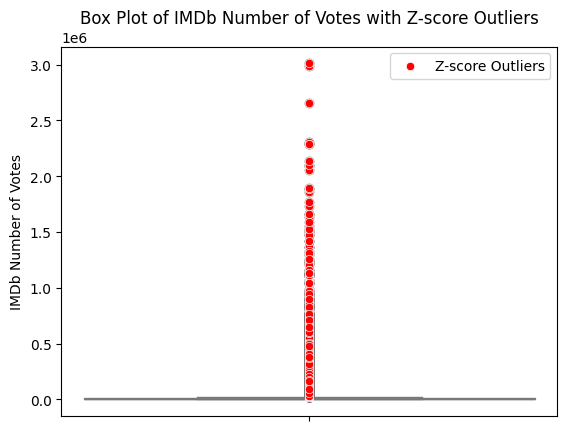

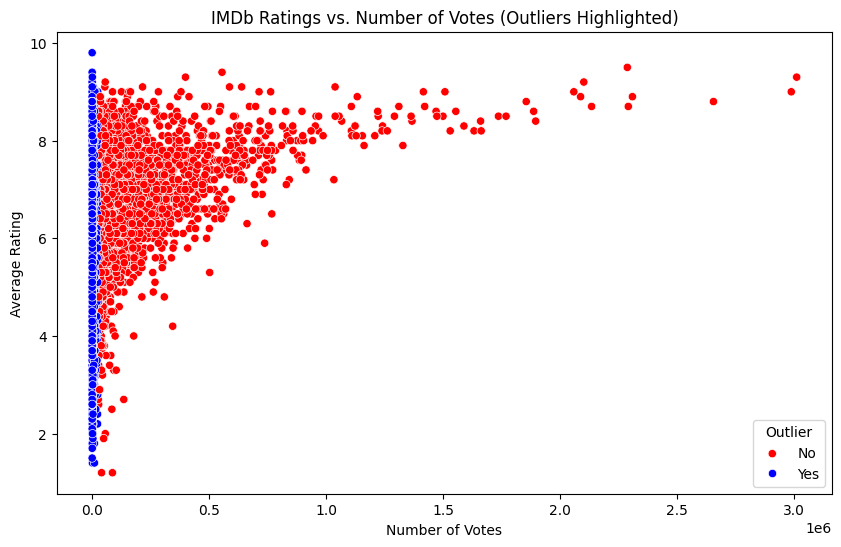

In [36]:
# Create a box plot for 'imdbNumVotes'
sns.boxplot(y=df_z['imdbNumVotes'], color='lightblue')

# Overlay outliers identified by Z-score
outliers = df_z[df_z['is_outlier']]
sns.scatterplot(y=outliers['imdbNumVotes'], x=[0]*len(outliers), color='red', label='Z-score Outliers', zorder=10)

plt.title('Box Plot of IMDb Number of Votes with Z-score Outliers')
plt.ylabel('IMDb Number of Votes')
plt.legend()
plt.show()

# Scatter Plot with Outliers Highlighted
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_iqr,
    x='imdbNumVotes', y='imdbAverageRating',
    hue='is_outlier',  # Color by outlier status
    palette={True: 'red', False: 'blue'},  # Red for outliers, blue for non-outliers
    legend='brief'
)

# Highlight outliers with annotations
for i in range(len(df_iqr)):
    if df_iqr['is_outlier'].iloc[i]:
        plt.text(
            df_iqr['imdbNumVotes'].iloc[i],
            df_iqr['imdbAverageRating'].iloc[i],
            s="", 
            fontsize=9,
            ha='right'
        )

plt.title('IMDb Ratings vs. Number of Votes (Outliers Highlighted)')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.legend(title='Outlier', labels=['No', 'Yes'])
plt.show()